In [1]:
%load_ext autoreload
%autoreload 2

In [541]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import *
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.preprocessing import QuantileTransformer
import scipy.stats as sci
import sklearn
sns.set_style("whitegrid")
sns.set_palette("deep")
#plt.style.use("seaborn-whitegrid")
from sklearn.model_selection import GridSearchCV
# import catboost as catb
# import lightgbm as lgb

from plot_mean_foehn_conditions import calculate_stability, plot_mean_foehn_condition_for_one_model, generate_coordinates_from_feature_label
from utils import *
from model_training import fit_model_on_all_ERA_features_and_return_most_important_features

# Define constants

In [3]:
LATS_CESM_STRING = ['4287', '4382', '4476', '4570', '4664', '4759', '4853', '4947']
LONS_CESM_STRING = ['0', '125', '250', '375', '500', '625', '750', '875', '1000', '1125', '1250', '1375', '1500']

MONTH_NAMES = ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dez"]

# Read ERA data

In [4]:
df_ERA_raw = pd.read_csv("data/MeteorologicalData/ERAI_data.csv.gz", parse_dates=["date"])

In [5]:
df_ERA = df_ERA_raw.copy()

# Load CESM data 

In [6]:
df_CESMp = pd.read_csv("data/MeteorologicalData/CESM_present_day.csv.gz")
df_CESMp["date"] = pd.to_datetime(df_CESMp["date"], format="%Y-%m-%dT%H:%M:00.000000Z") # Due to Dataiku date format
CESMp_features = set(df_CESMp.columns)

In [7]:
df_CESMf = pd.read_csv("data/MeteorologicalData/CESM_future_day.csv.gz")
df_CESMf["date"] = pd.to_datetime(df_CESMf["date"], format="%Y-%m-%dT%H:%M:00.000000Z") # Due to Dataiku date format
CESMf_features = set(df_CESMf.columns)

In [8]:
# Calculate and append the stability parameters
df_CESMp = calculate_stability(df = df_CESMp, lats = LATS_CESM_STRING, lons = LONS_CESM_STRING)
df_CESMf = calculate_stability(df = df_CESMf, lats = LATS_CESM_STRING, lons = LONS_CESM_STRING)

# Create pot. temp features for CESMp
df_T= df_CESMp.filter(regex=("T\w+900")).add_prefix("PHI")
df_PHIT_900 = calc_pot_temp(T=df_T, p = 900.0)
df_T= df_CESMp.filter(regex=("T\w+850")).add_prefix("PHI")
df_PHIT_850 = calc_pot_temp(T=df_T, p = 850.0)
df_T= df_CESMp.filter(regex=("T\w+700")).add_prefix("PHI")
df_PHIT_700 = calc_pot_temp(T=df_T, p = 700.0)
df_CESMp = pd.concat([df_CESMp, df_PHIT_900, df_PHIT_850, df_PHIT_700], axis=1)

# Create pot. temp features for CESMf
df_T= df_CESMf.filter(regex=("T\w+900")).add_prefix("PHI")
df_PHIT_900 = calc_pot_temp(T=df_T, p = 900.0)
df_T= df_CESMf.filter(regex=("T\w+850")).add_prefix("PHI")
df_PHIT_850 = calc_pot_temp(T=df_T, p = 850.0)
df_T= df_CESMf.filter(regex=("T\w+700")).add_prefix("PHI")
df_PHIT_700 = calc_pot_temp(T=df_T, p = 700.0)
df_CESMf = pd.concat([df_CESMf, df_PHIT_900, df_PHIT_850, df_PHIT_700], axis=1)

del df_PHIT_900, df_PHIT_850, df_PHIT_700

Pressure lvl doesnt exist (700-900 hPa, 4287, 0)
Pressure lvl doesnt exist (850-900 hPa, 4287, 0)
Pressure lvl doesnt exist (700-900 hPa, 4287, 125)
Pressure lvl doesnt exist (850-900 hPa, 4287, 125)
Pressure lvl doesnt exist (700-900 hPa, 4382, 250)
Pressure lvl doesnt exist (850-900 hPa, 4382, 250)
Pressure lvl doesnt exist (700-900 hPa, 4382, 375)
Pressure lvl doesnt exist (850-900 hPa, 4382, 375)
Pressure lvl doesnt exist (700-900 hPa, 4382, 500)
Pressure lvl doesnt exist (850-900 hPa, 4382, 500)
Pressure lvl doesnt exist (700-900 hPa, 4476, 250)
Pressure lvl doesnt exist (850-900 hPa, 4476, 250)
Pressure lvl doesnt exist (700-900 hPa, 4476, 375)
Pressure lvl doesnt exist (850-900 hPa, 4476, 375)
Pressure lvl doesnt exist (700-900 hPa, 4476, 500)
Pressure lvl doesnt exist (850-900 hPa, 4476, 500)
Pressure lvl doesnt exist (700-900 hPa, 4476, 625)
Pressure lvl doesnt exist (850-900 hPa, 4476, 625)
Pressure lvl doesnt exist (700-900 hPa, 4476, 750)
Pressure lvl doesnt exist (850-900 

# Use only features which are also in CESM and which are not in the Alps

In [9]:
# Only allow features which also exist in CESM
intersecting_features = list(CESMp_features.intersection(CESMf_features).intersection(set(df_ERA.columns)))
df_ERA = df_ERA[intersecting_features]

In [10]:
# Cut Alps as an rectangle and drop those features
lat_features_to_cut = set(df_ERA.loc[0:1,:].filter(regex=("\w+(4570|4664|4759)\w+")).columns)
lon_features_to_cut = set(df_ERA.loc[0:1,:].filter(regex=("\w+(500|625|750|875|1000|1125|1250)\w+")).columns)

intersecting_features = lat_features_to_cut.intersection(lon_features_to_cut)

df_ERA.drop(intersecting_features, axis=1, inplace=True)

In [11]:
df_ERA

,V_4947_375_700,U_4382_1250_700,V_4476_1500_500,U_4853_1375_500,SLP_4287_1375_sealevel,SLP_4947_375_sealevel,V_4570_375_850,Z_4947_375_500,U_4287_250_500,T_4853_1375_500,...,V_4287_750_700,Z_4287_1500_700,Z_4287_1125_700,U_4853_1125_700,V_4382_125_850,V_4853_125_500,T_4759_125_900,V_4476_1250_500,U_4853_750_850,Z_4382_250_850
0,-8.778254,-1.949725,-12.080680,6.074563,1002.307373,1013.034302,-5.028343,5346.677734,22.202852,-35.617214,...,-8.577211,2771.997314,2865.590820,11.424900,-1.146921,-16.085457,-1.368560,-13.048079,11.922429,1441.265381
1,-5.969459,6.595381,-15.106171,4.169692,1006.319641,1011.824036,-1.439861,5334.997559,21.233097,-36.231441,...,-5.228330,2838.875977,2882.494385,12.056975,-0.258394,-15.058628,-2.172589,-17.861540,9.751382,1402.756226
2,-7.172423,9.040929,-13.881407,8.926577,1008.062195,1011.895081,-2.484225,5324.791016,19.499496,-35.856552,...,-6.662611,2875.718018,2893.721191,9.898549,-8.805115,-14.496703,-2.371656,-16.837437,8.510113,1405.742554
3,-9.801356,8.455927,-10.893802,11.962904,1007.607483,1012.361206,-5.339229,5308.489746,16.282488,-36.779865,...,-9.883936,2885.203369,2889.862061,9.748493,-8.743429,-14.535955,-2.136600,-9.775720,7.582114,1415.590576
4,-10.778939,7.538810,-4.128820,11.427619,1006.972961,1014.443176,-5.652349,5296.888184,27.662922,-38.135056,...,-11.948767,2881.810303,2880.795410,10.759873,-9.843168,-17.803823,-4.384941,-5.584256,6.676454,1408.092163
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
57947,2.228271,0.337566,-1.044113,-3.131036,1016.648926,1019.896667,-2.678375,5850.551758,-0.929989,-11.522769,...,2.834808,3194.435547,3194.779541,-1.892978,-3.329445,-2.111422,22.021383,-3.146672,-2.403204,1566.512207
57948,7.171435,-1.341656,1.529859,-2.758779,1016.616760,1018.915710,2.293048,5841.269531,1.278540,-11.690927,...,5.708480,3187.621582,3186.119385,-3.454876,1.690555,-1.913230,20.969135,-0.290249,-4.592199,1558.928589
57949,5.805546,-4.724221,0.828513,-2.974693,1015.655273,1015.289551,4.169058,5818.098633,0.777219,-11.889299,...,0.070062,3184.231201,3176.795166,-0.746076,1.456576,1.017483,20.575178,0.740484,-1.895120,1547.610962
57950,6.758009,-0.180292,2.388351,-0.065320,1014.718567,1011.410828,3.076540,5799.322754,-0.617119,-11.372659,...,1.046752,3172.230225,3163.762451,0.709535,0.770189,11.030643,18.989172,3.255139,2.722509,1545.667725


# Calculate derived variables

In [12]:
# Sealevel pressure differences
df_pressures = df_ERA.filter(regex=("SLP_\w+"))

pressure_list = sorted(df_pressures.columns.tolist())
pressure_list_dummy = sorted(df_pressures.columns.tolist())

SLP_dict = {}
for col1 in pressure_list:
    pressure_list_dummy.remove(col1)
    for col2 in pressure_list_dummy:
        SLP_dict[f"diff_{col1}_{col2}"] = (df_pressures.loc[:, col1] - df_pressures.loc[:, col2]).values

#df_pressures = pd.concat([df_pressures, pd.DataFrame(SLP_dict)], axis = 1)
df_pressures = pd.DataFrame(SLP_dict)

del SLP_dict

In [13]:
# Geopotential height (on 850 and 700 hPa)

df_Z = df_ERA.filter(regex=("Z_\w+"))
Z_dict = {}

for level in ["850", "700"]:
    df_Z_level = df_Z.filter(regex=("Z_\w+" + level))

    Z_list = sorted(df_Z_level.columns.tolist())
    Z_list_dummy = sorted(df_Z_level.columns.tolist())

    for col1 in Z_list:
        Z_list_dummy.remove(col1)
        for col2 in Z_list_dummy:
            Z_dict[f"diff_{col1}_{col2}"] = (df_Z_level.loc[:, col1] - df_Z_level.loc[:, col2]).values

#df_Z = pd.concat([df_Z, pd.DataFrame(Z_dict)], axis = 1)
df_Z = pd.DataFrame(Z_dict)

del df_Z_level, Z_dict

In [14]:
# Vertical potential temperature differences (on 850 hPa)

df_T = df_ERA.filter(regex=("T_\w+850"))
df_PHIT = calc_pot_temp(T=df_T+273.15, p=850.0).add_prefix("PHI")
PHIT_dict = {}

PHIT_list = sorted(df_PHIT.columns.tolist())
PHIT_list_dummy = sorted(df_PHIT.columns.tolist())

for col1 in PHIT_list:
    PHIT_list_dummy.remove(col1)
    for col2 in PHIT_list_dummy:
        PHIT_dict[f"diff_{col1}_{col2}"] = (df_PHIT.loc[:, col1] - df_PHIT.loc[:, col2]).values

#df_PHIT = pd.concat([df_PHIT, pd.DataFrame(PHIT_dict)], axis = 1)
df_PHIT = pd.DataFrame(PHIT_dict)

del df_T, PHIT_dict

In [15]:
# Stability variables

df_T= df_ERA.filter(regex=("T\w+900")).add_prefix("PHI")
df_PHIT_900 = calc_pot_temp(T=df_T+273.15, p = 900.0)
df_T= df_ERA.filter(regex=("T\w+850")).add_prefix("PHI")
df_PHIT_850 = calc_pot_temp(T=df_T+273.15, p = 850.0)
df_T= df_ERA.filter(regex=("T\w+700")).add_prefix("PHI")
df_PHIT_700 = calc_pot_temp(T=df_T+273.15, p = 700.0)


stability_dict = {}
for lat in LATS_CESM_STRING:
    for lon in LONS_CESM_STRING:
        try:
            stability_dict[f"DELTAPHI_{lat}_{lon}_850"] = (df_PHIT_850.loc[:, f"PHIT_{lat}_{lon}_850"] - df_PHIT_900.loc[:, f"PHIT_{lat}_{lon}_900"]).values
            stability_dict[f"DELTAPHI_{lat}_{lon}_700"] = (df_PHIT_700.loc[:, f"PHIT_{lat}_{lon}_700"] - df_PHIT_900.loc[:, f"PHIT_{lat}_{lon}_900"]).values
        except:
            print("Variable does not exist at this location.")
df_stability = pd.DataFrame(stability_dict)

del df_T, df_PHIT_900, df_PHIT_850, df_PHIT_700, stability_dict

Variable does not exist at this location.
Variable does not exist at this location.
Variable does not exist at this location.
Variable does not exist at this location.
Variable does not exist at this location.
Variable does not exist at this location.
Variable does not exist at this location.
Variable does not exist at this location.
Variable does not exist at this location.
Variable does not exist at this location.
Variable does not exist at this location.
Variable does not exist at this location.
Variable does not exist at this location.
Variable does not exist at this location.
Variable does not exist at this location.
Variable does not exist at this location.
Variable does not exist at this location.
Variable does not exist at this location.
Variable does not exist at this location.
Variable does not exist at this location.
Variable does not exist at this location.
Variable does not exist at this location.
Variable does not exist at this location.
Variable does not exist at this lo

In [16]:
# Wind velocities
df_wind = df_ERA.filter(regex=("(U|V)\w+")).copy()

In [17]:
df_ERA = pd.concat([df_ERA["date"], 
                     df_pressures, 
                     df_Z, 
                     df_PHIT, 
                     df_stability, 
                     df_wind], 
                    axis = 1)

# Merge in foehn data at specified location

In [678]:
location="LUG"
foehn_type={"ALT": "SouthFoehn", "LUG": "NorthFoehn"}
df_foehn_raw = pd.read_csv(f"data/FoehnData/{location}_foehn.csv", parse_dates=["date"])
df_foehn_raw.dropna(inplace=True, how="any", axis=0)

In [679]:
# Merge ERAI and foehn data
df_ERA_all_features = pd.merge(df_foehn_raw, df_ERA, on="date", how="inner")

# Train Model on full data

In [680]:
# Create train and test mask
test_mask = (df_ERA_all_features["date"]>np.datetime64("1991-01-01 00:00")) & (df_ERA_all_features["date"]<np.datetime64("2000-12-31 23:00"))
train_mask = (test_mask == False)

In [681]:
# Create list of all features for prediction
feature_names=df_ERA_all_features.columns.tolist()
feature_names.remove("date")
feature_names.remove("Foehn")

In [682]:
# model_cat = catb.CatBoostClassifier(loss_function='Logloss',
#                                 verbose=True,
#                                 scale_pos_weight=20,
#                                 thread_count=20,
#                                 max_depth=4, 
#                                 learning_rate=0.1, 
#                                 n_estimators=1000,
#                                 reg_lambda=10,
#                                    random_state=42)

# df_ERA_feature_importances = fit_clf_on_all_features(model_cat, df_ERA_all_features, feature_names)

In [ ]:
# Fit a global classifier on all features
model_xg = xgb.XGBClassifier(
                    max_depth=4,
                    learning_rate=0.1,
                    gamma=0.0,
                    min_child_weight=0.0,
                    max_delta_step=0.0,
                    subsample=1.0,
                    colsample_bytree=1.0,
                    colsample_bylevel=1.0,
                    reg_alpha=100.0,
                    reg_lambda=1.0,
                    n_estimators=100,
                    verbosity=0,
                    nthread=5,
                    scale_pos_weight=20.0,
                    base_score=0.05,
                    seed=1337,
                    missing=None,
                  )
params = {"n_estimators": [50,100,200], 'max_depth': [4,5], 'learning_rate': [0.1, 0.2], "reg_alpha": [1], "reg_lambda":[10,100]}
#params = {'max_depth': [2], 'learning_rate': [0.2], "reg_alpha": [1], "reg_lambda":[100]}

df_ERA_feature_importances = fit_model_on_all_ERA_features_and_return_most_important_features(model_xg, params, df_ERA_all_features, feature_names, train_mask, test_mask, with_CV=True)

Started
Fitting 3 folds for each of 24 candidates, totalling 72 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.


In [684]:
df_ERA_feature_importances.loc[0:50, :]

,feature_name,importance
0,diff_Z_4570_1375_850_Z_4664_375_850,0.256659
1,diff_PHIT_4382_750_850_PHIT_4853_625_850,0.047241
2,diff_SLP_4476_1125_sealevel_SLP_4853_875_sealevel,0.033464
3,diff_Z_4570_125_700_Z_4853_1500_700,0.016654
4,V_4476_625_850,0.013138
5,diff_PHIT_4947_1500_850_PHIT_4947_875_850,0.008038
6,diff_Z_4382_500_850_Z_4382_625_850,0.007145
7,diff_PHIT_4476_750_850_PHIT_4759_1375_850,0.006329
8,diff_SLP_4476_1250_sealevel_SLP_4853_750_sealevel,0.006092
9,diff_PHIT_4287_1125_850_PHIT_4853_1000_850,0.006073


# Reduce dataframe to most important features

In [931]:
df_ERA_reduced_features = df_ERA_all_features.loc[:,df_ERA_feature_importances.loc[:250, "feature_name"]]
feature_names_reduced = df_ERA_reduced_features.columns.tolist()
df_ERA_reduced_features["date"] = df_ERA_all_features["date"]
df_ERA_reduced_features["Foehn"] = df_ERA_all_features["Foehn"]

# Transform features to quantiles on ERA

In [932]:
quantile_scaler_ERA = QuantileTransformer(subsample=10**(6), random_state=42)
quantile_scaler_ERA.fit(df_ERA_reduced_features.loc[train_mask, feature_names_reduced]) # Only fit on training data

df_ERA_reduced_features_scaled = pd.DataFrame(quantile_scaler_ERA.transform(df_ERA_reduced_features.loc[:, feature_names_reduced]), 
                                              columns = feature_names_reduced, 
                                              index=df_ERA_reduced_features.index)
df_ERA_reduced_features_scaled["date"] = df_ERA_all_features["date"]
df_ERA_reduced_features_scaled["Foehn"] = df_ERA_all_features["Foehn"]

# Generate and preprocess CESM features

In [933]:
# Create features which are used by the simplified model
feature_dict_CESMp = {}
feature_dict_CESMf = {}
for feature_name in feature_names_reduced:
    if feature_name[0:6] == "diff_S":
        feature_name_splitted = feature_name.split("_")
        first_feature = "_".join(feature_name_splitted[1:5])
        second_feature = "_".join(feature_name_splitted[5:9])
        
        feature_dict_CESMp[f"diff_{first_feature}_{second_feature}"] = (df_CESMp.loc[:, first_feature] - df_CESMp.loc[:, second_feature]).values
        feature_dict_CESMf[f"diff_{first_feature}_{second_feature}"] = (df_CESMf.loc[:, first_feature] - df_CESMf.loc[:, second_feature]).values

    elif feature_name[0:6] == "diff_Z":
        feature_name_splitted = feature_name.split("_")
        first_feature = "_".join(feature_name_splitted[1:5])
        second_feature = "_".join(feature_name_splitted[5:9])
        
        feature_dict_CESMp[f"diff_{first_feature}_{second_feature}"] = (df_CESMp.loc[:, first_feature] - df_CESMp.loc[:, second_feature]).values
        feature_dict_CESMf[f"diff_{first_feature}_{second_feature}"] = (df_CESMf.loc[:, first_feature] - df_CESMf.loc[:, second_feature]).values

    elif feature_name[0:6] == "diff_P":
        feature_name_splitted = feature_name.split("_")
        first_feature = "_".join(feature_name_splitted[1:5])
        second_feature = "_".join(feature_name_splitted[5:9])
        
        feature_dict_CESMp[f"diff_{first_feature}_{second_feature}"] = (df_CESMp.loc[:, first_feature] - df_CESMp.loc[:, second_feature]).values
        feature_dict_CESMf[f"diff_{first_feature}_{second_feature}"] = (df_CESMf.loc[:, first_feature] - df_CESMf.loc[:, second_feature]).values

    elif feature_name[0:6] == "DELTAP":
        feature_name_splitted = feature_name.split("_")
        first_feature = "PHIT_" + "_".join(feature_name_splitted[1:4])
        second_feature = "PHIT_" + "_".join(feature_name_splitted[1:3]) + "_900"
        
        feature_dict_CESMp["DELTAPHI_" +"_".join(feature_name_splitted[1:4])] = (df_CESMp.loc[:, first_feature] - df_CESMp.loc[:, second_feature]).values
        feature_dict_CESMf["DELTAPHI_" +"_".join(feature_name_splitted[1:4])] = (df_CESMf.loc[:, first_feature] - df_CESMf.loc[:, second_feature]).values
    
    else:
        feature_dict_CESMp[feature_name] = df_CESMp.loc[:, feature_name].values
        feature_dict_CESMf[feature_name] = df_CESMf.loc[:, feature_name].values

feature_dict_CESMp["date"] =df_CESMp.loc[:, "date"].values
feature_dict_CESMf["date"] =df_CESMf.loc[:, "date"].values

feature_dict_CESMp["ensemble"] =df_CESMp.loc[:, "ensemble"].values
feature_dict_CESMf["ensemble"] =df_CESMf.loc[:, "ensemble"].values

df_CESMp_reduced_features = pd.DataFrame(feature_dict_CESMp)
df_CESMf_reduced_features = pd.DataFrame(feature_dict_CESMf)

In [934]:
quantile_scaler_CESM = QuantileTransformer(subsample=10**(6), random_state=42)
quantile_scaler_CESM.fit(df_CESMp_reduced_features.loc[:, feature_names_reduced])

df_CESMp_reduced_features_scaled = pd.DataFrame(quantile_scaler_CESM.transform(df_CESMp_reduced_features.loc[:, feature_names_reduced]), 
                                                columns = feature_names_reduced, 
                                                index=df_CESMp_reduced_features.loc[:, feature_names_reduced].index)

df_CESMf_reduced_features_scaled = pd.DataFrame(quantile_scaler_CESM.transform(df_CESMf_reduced_features.loc[:, feature_names_reduced]), 
                                                columns = feature_names_reduced, 
                                                index=df_CESMf_reduced_features.loc[:, feature_names_reduced].index)

df_CESMp_reduced_features_scaled["date"] = df_CESMp_reduced_features["date"]
df_CESMf_reduced_features_scaled["date"] = df_CESMf_reduced_features["date"]

df_CESMp_reduced_features_scaled["ensemble"] = df_CESMp_reduced_features["ensemble"]
df_CESMf_reduced_features_scaled["ensemble"] = df_CESMf_reduced_features["ensemble"]

# Fit XGBoost to reduced feature set & evaluate

In [935]:
# def plot_metrics_by_month(precision_scores, recall_scores, f1_scores):
#     plt.figure(figsize=(16,9))
#     plt.plot(MONTH_NAMES, precision_scores)
#     plt.plot(MONTH_NAMES, recall_scores)
#     plt.plot(MONTH_NAMES, f1_scores)
#     plt.legend(["precision", "recall", "f1-score"])

In [936]:
# def get_best_model_through_CV(model, parameters_CV):
#     # Fit model
#     model_CV = GridSearchCV(model, parameters_CV, cv=3, n_jobs=5, scoring='neg_log_loss')
#     model_CV.fit(df_ERA_reduced_features_scaled.loc[train_mask, feature_names_reduced], 
#                  df_ERA_reduced_features_scaled.loc[train_mask, "Foehn"])
#     print(model_CV.best_params_)
    
#     # Predict and optimize threshold
#     best_model = model_CV.best_estimator_
#     df_ERA_reduced_features_scaled.loc[:, "prediction_proba"] = best_model.predict_proba(df_ERA_reduced_features_scaled.loc[:, feature_names_reduced])[:,1]
#     precisions, recalls, thresholds = precision_recall_curve(df_ERA_reduced_features_scaled.loc[test_mask, "Foehn"], 
#                                                              df_ERA_reduced_features_scaled.loc[test_mask, "prediction_proba"])
#     best_threshold_ERA = thresholds[np.argmin(abs(precisions-recalls))]
#     df_ERA_reduced_features_scaled.loc[:, "prediction"] = (df_ERA_reduced_features_scaled.loc[:, "prediction_proba"]> best_threshold_ERA).astype(int)
    
#     # Plot model evaluation curves
# #     f = plt.figure(figsize=(12,5))
# #     f.add_subplot(121)
# #     sns.lineplot(precisions, recalls)
# #     f.add_subplot(122)
# #     sns.lineplot(np.append(thresholds, 1.0), precisions)
# #     sns.lineplot(np.append(thresholds, 1.0), recalls)
    
#     # Print model evaluation scores
    
#     df_ERA_reduced_features_scaled.loc[test_mask, "prediction"]
#     print(f"Best threshold: {best_threshold_ERA}")
#     print(f'Precision: {precision_score(df_ERA_reduced_features_scaled.loc[test_mask, "Foehn"], df_ERA_reduced_features_scaled.loc[test_mask, "prediction"])}')
#     print(f'Recall: {recall_score(df_ERA_reduced_features_scaled.loc[test_mask, "Foehn"], df_ERA_reduced_features_scaled.loc[test_mask, "prediction"])}')
#     print(confusion_matrix(df_ERA_reduced_features_scaled.loc[test_mask, "Foehn"], df_ERA_reduced_features_scaled.loc[test_mask, "prediction"]))
#     display(pd.DataFrame({"feature_name": feature_names_reduced, "importance": best_model.feature_importances_}).sort_values(by="importance", ascending=False).reset_index(drop=True).head(10))
    
#     precision_scores, recall_scores, f1_scores = [], [], []
#     for month in range(1,12+1):
#         test_mask_month =  test_mask & (df_ERA_reduced_features_scaled["date"].dt.month == month)
#         precision = precision_score(df_ERA_reduced_features_scaled.loc[test_mask_month, "Foehn"], df_ERA_reduced_features_scaled.loc[test_mask_month, "prediction"])
#         recall = recall_score(df_ERA_reduced_features_scaled.loc[test_mask_month, "Foehn"], df_ERA_reduced_features_scaled.loc[test_mask_month, "prediction"])
#         f1score = f1_score(df_ERA_reduced_features_scaled.loc[test_mask_month, "Foehn"], df_ERA_reduced_features_scaled.loc[test_mask_month, "prediction"])
#         precision_scores.append(precision)
#         recall_scores.append(recall)
#         f1_scores.append(f1score)

#     plot_metrics_by_month(precision_scores, recall_scores, f1_scores)
    
   
#     return best_model, best_threshold_ERA

In [937]:
# from sklearn.model_selection import cross_validate

# def train_model_for_each_month(model, parameters):
#     models_retrained_list, thresholds_list = [], []
    
#     precision_scores, recall_scores, f1_scores = [], [], []
    
#     plt.figure(figsize=(16,9))
#     for month in range(1,12+1):
#         # Define train and test masks
#         train_mask_month = train_mask & (df_ERA_reduced_features_scaled["date"].dt.month == month)
#         test_mask_month =  test_mask & (df_ERA_reduced_features_scaled["date"].dt.month == month)
#         all_mask_month =  (df_ERA_reduced_features_scaled["date"].dt.month == month)
        
#         # CV
# #         model.set_params(scale_pos_weight=df_ERA_reduced_features_scaled.loc[train_mask_month, "Foehn"].count()/df_ERA_reduced_features_scaled.loc[train_mask_month, "Foehn"].sum())
# #         print(model.get_params())
#         model_CV = GridSearchCV(model, parameters, cv=[(slice(None), slice(None))], n_jobs=4, scoring=custom_metric_for_month, verbose=1)
#         model_CV.fit(df_ERA_reduced_features_scaled.loc[train_mask_month, feature_names_reduced], 
#                      df_ERA_reduced_features_scaled.loc[train_mask_month, "Foehn"])
#         print(model_CV.cv_results_["mean_test_score"])
#         # Get feature importance
# #         print(dict(zip(feature_names_reduced, model_CV.best_estimator_.feature_importances_)))
        
#         # Optimize threshold
#         best_model = model_CV.best_estimator_
#         df_ERA_reduced_features_scaled.loc[all_mask_month, "prediction_proba"] = best_model.predict_proba(df_ERA_reduced_features_scaled.loc[all_mask_month, feature_names_reduced])[:,1]
#         precisions, recalls, thresholds = precision_recall_curve(df_ERA_reduced_features_scaled.loc[test_mask_month, "Foehn"], 
#                                                                  df_ERA_reduced_features_scaled.loc[test_mask_month, "prediction_proba"])
#         best_threshold_ERA = thresholds[np.argmin(abs(precisions-recalls))]
#         df_ERA_reduced_features_scaled.loc[all_mask_month, "prediction"] = (df_ERA_reduced_features_scaled.loc[all_mask_month, "prediction_proba"]>best_threshold_ERA).astype(int)
        
#         # Print model evaluation scores
#         precision = precision_score(df_ERA_reduced_features_scaled.loc[test_mask_month, "Foehn"], df_ERA_reduced_features_scaled.loc[test_mask_month, "prediction"])
#         recall = recall_score(df_ERA_reduced_features_scaled.loc[test_mask_month, "Foehn"], df_ERA_reduced_features_scaled.loc[test_mask_month, "prediction"])
#         f1score = f1_score(df_ERA_reduced_features_scaled.loc[test_mask_month, "Foehn"], df_ERA_reduced_features_scaled.loc[test_mask_month, "prediction"])
#         precision_scores.append(precision)
#         recall_scores.append(recall)
#         f1_scores.append(f1score)
        
#         print(f"Best threshold: {best_threshold_ERA}")
#         print(f'Precision: {precision}')
#         print(f'Recall: {recall}')
#         print(confusion_matrix(df_ERA_reduced_features_scaled.loc[test_mask_month, "Foehn"], df_ERA_reduced_features_scaled.loc[test_mask_month, "prediction"]))
#         display(pd.DataFrame({"feature_name": feature_names_reduced, "importance": best_model.feature_importances_}).sort_values(by="importance", ascending=False).reset_index(drop=True).head(10))
        
#         # Retrain model on full data
#         best_model.fit(df_ERA_reduced_features_scaled.loc[all_mask_month, feature_names_reduced], 
#                        df_ERA_reduced_features_scaled.loc[all_mask_month, "Foehn"])
#         models_retrained_list.append(best_model)
#         thresholds_list.append(best_threshold_ERA)
        
#     plot_metrics_by_month(precision_scores, recall_scores, f1_scores)
#     return models_retrained_list, thresholds_list

In [938]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def custom_loss(predt: np.ndarray, dtrain: xgb.DMatrix, ERA_len, CESM_len, alpha=90000):
    y = dtrain.get_label()[:ERA_len]
    
    pred = sigmoid(predt)
    pred_ERA = pred[:ERA_len]
    pred_CESM = pred[ERA_len:]
    
    grad_logloss  = pred_ERA - y
    hess_logloss = pred_ERA*(1.0 - pred_ERA)
    
    grad_custom = 2*alpha/CESM_len*pred_CESM*(1-pred_CESM)*(np.mean(pred_CESM)-np.mean(y))
    hess_custom = 2*alpha/CESM_len*pred_CESM*(1-pred_CESM)*((1-pred_CESM)*(np.mean(pred_CESM)-np.mean(y)) -
                                                            pred_CESM*(np.mean(pred_CESM)-np.mean(y)) +
                                                            pred_CESM*(1-pred_CESM)/CESM_len
                                                            )
    
    grad = np.zeros(len(predt))
    grad[:ERA_len] = grad_logloss
    grad[ERA_len:] = grad_custom
    
    hess = np.zeros(len(predt))
    hess[:ERA_len] = hess_logloss
    hess[ERA_len:] = hess_custom
    
    return grad, hess

In [951]:
params = {'max_depth': 4, 'learning_rate': 0.25, "reg_alpha":1, "reg_lambda":20, "n_jobs": 25,"verbosity":1, "seed": 0}

models_retrained_list, thresholds_list = [], []
precision_scores, recall_scores, f1_scores= [], [], []

most_important_features = dict()


# Train first on all data
D_train = xgb.DMatrix(df_ERA_reduced_features_scaled.loc[train_mask, feature_names_reduced],
                      label=df_ERA_reduced_features_scaled.loc[train_mask, "Foehn"], 
                      weight=df_ERA_reduced_features_scaled.loc[train_mask, "Foehn"]*20+1)
model_ges = xgb.Booster(params, [D_train])
model_ges = xgb.train(params, dtrain = D_train, num_boost_round=20, xgb_model=model_ges)

print("Done Fitting on whole Dataset")

total_confusion_matrix= np.zeros((2,2))

for month in range(1,12+1):
    print(MONTH_NAMES[month-1])
    
    # Define masks to address specific parts of data set
    # ERA masks
    train_mask_month = train_mask & (df_ERA_reduced_features_scaled["date"].dt.month == month)
    test_mask_month = test_mask & (df_ERA_reduced_features_scaled["date"].dt.month == month)
    month_mask_ERA = (df_ERA_reduced_features_scaled["date"].dt.month == month)
    
    month_mask_CESMp = (df_CESMp_reduced_features_scaled["date"].dt.month == month)

    # Build training dataset from ERA and CESMp
    df_ERA_CESMp = pd.concat([df_ERA_reduced_features_scaled.loc[train_mask_month, feature_names_reduced + ["Foehn"]], 
                              df_CESMp_reduced_features_scaled.loc[month_mask_CESMp, feature_names_reduced]],
                            axis=0)
    
    
    D_train = xgb.DMatrix(df_ERA_CESMp[feature_names_reduced], label=df_ERA_CESMp["Foehn"], weight=(df_ERA_CESMp["Foehn"]*20+1))
    
    # Train model
    #model = xgb.Booster(params, [D_train])
    model = model_ges.copy()
    for _ in range(190):
        pred = model.predict(D_train)
        g, h = custom_loss(pred, D_train, ERA_len=train_mask_month.sum(), CESM_len = month_mask_CESMp.sum())
        model.boost(D_train, g, h)
    
    
    # Make prediction on whole data
    D_total = xgb.DMatrix(df_ERA_reduced_features_scaled.loc[month_mask_ERA, feature_names_reduced])
    yhat = sigmoid(model.predict(D_total))
    
    
    df_ERA_reduced_features_scaled.loc[month_mask_ERA, "prediction_proba"] = yhat
    
    # Calculate metrics on test set & identify best threshold
    precisions, recalls, thresholds = precision_recall_curve(df_ERA_reduced_features_scaled.loc[test_mask_month, "Foehn"], 
                                                             df_ERA_reduced_features_scaled.loc[test_mask_month, "prediction_proba"])
    best_threshold_ERA = thresholds[np.argmin(abs(precisions-recalls))-1]
    thresholds_list.append(best_threshold_ERA)
    
    # Make final prediciton for ERA
    df_ERA_reduced_features_scaled.loc[month_mask_ERA, "prediction"] = (df_ERA_reduced_features_scaled.loc[month_mask_ERA, "prediction_proba"]>best_threshold_ERA).astype(int)

    # Print model evaluation scores
    precision = precision_score(df_ERA_reduced_features_scaled.loc[test_mask_month, "Foehn"], df_ERA_reduced_features_scaled.loc[test_mask_month, "prediction"])
    recall = recall_score(df_ERA_reduced_features_scaled.loc[test_mask_month, "Foehn"], df_ERA_reduced_features_scaled.loc[test_mask_month, "prediction"])
    f1score = f1_score(df_ERA_reduced_features_scaled.loc[test_mask_month, "Foehn"], df_ERA_reduced_features_scaled.loc[test_mask_month, "prediction"])
    precision_scores.append(precision)
    recall_scores.append(recall)
    f1_scores.append(f1score)
    total_confusion_matrix += confusion_matrix(df_ERA_reduced_features_scaled.loc[test_mask_month, "Foehn"], df_ERA_reduced_features_scaled.loc[test_mask_month, "prediction"])


    print(f"Best threshold: {best_threshold_ERA}")
    print(f'Precision: {precision}')
    print(f'Recall: {recall}')
    print(confusion_matrix(df_ERA_reduced_features_scaled.loc[test_mask_month, "Foehn"], df_ERA_reduced_features_scaled.loc[test_mask_month, "prediction"]))
    
    importances_month = pd.DataFrame.from_dict(model.get_score(importance_type='gain'), orient="index", columns=["importance"]).sort_values(by="importance", ascending=False)
    #display(importances_month.head(10))
    
    
    for row in importances_month.head(30).iterrows():
        if row[0] in most_important_features.keys():
            most_important_features[row[0]] += row[1][0]
        else:
            most_important_features[row[0]] = row[1][0]
    
    models_retrained_list.append(model)

Done Fitting on whole Dataset
Jan
Best threshold: 0.44580721855163574
Precision: 0.7076923076923077
Recall: 0.7076923076923077
[[1155   19]
 [  19   46]]
Feb
Best threshold: 0.5343574285507202
Precision: 0.7156862745098039
Recall: 0.7156862745098039
[[1001   29]
 [  29   73]]
Mar
Best threshold: 0.5659318566322327
Precision: 0.7559523809523809
Recall: 0.7559523809523809
[[1031   41]
 [  41  127]]
Apr
Best threshold: 0.5475097894668579
Precision: 0.7247706422018348
Recall: 0.7247706422018348
[[1061   30]
 [  30   79]]
May
Best threshold: 0.5189180970191956
Precision: 0.7916666666666666
Recall: 0.7916666666666666
[[1153   15]
 [  15   57]]
Jun
Best threshold: 0.49254077672958374
Precision: 0.7213114754098361
Recall: 0.7213114754098361
[[1122   17]
 [  17   44]]
Jul
Best threshold: 0.37801724672317505
Precision: 0.6842105263157895
Recall: 0.6842105263157895
[[1140   24]
 [  24   52]]
Aug
Best threshold: 0.5291157960891724
Precision: 0.65
Recall: 0.65
[[1186   14]
 [  14   26]]
Sep
Best th

[[13400.   269.]
 [  269.   673.]]
Accuracyn: 0.9631784272123742
Precision: 0.7144373673036093
Recall: 0.7144373673036093
ROC-AUC: 0.9794579114114274
Log-Loss: 0.09446512446736809
Saved figure at: /home/chmony/Documents/Results/newgradient/monthly_scores_ERAI_NorthFoehn.pdf


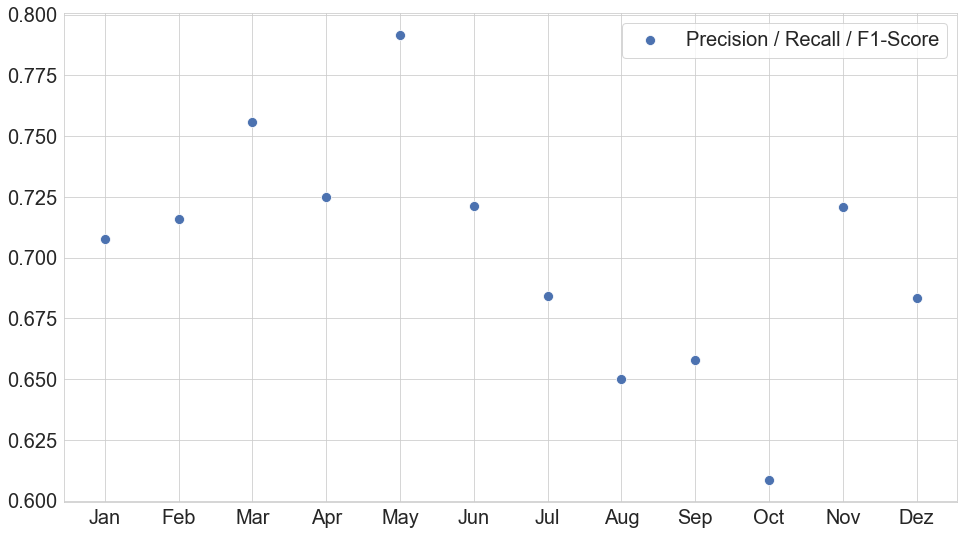

In [976]:
plt.rcParams.update({'font.size': 20})

print(total_confusion_matrix)
print(f'Accuracyn: {(total_confusion_matrix[1,1]+total_confusion_matrix[0,0])/total_confusion_matrix[:,:].sum()}')
print(f'Precision: {total_confusion_matrix[1,1]/total_confusion_matrix[:,1].sum()}')
print(f'Recall: {total_confusion_matrix[1,1]/total_confusion_matrix[1,:].sum()}')
print(f'ROC-AUC: {roc_auc_score(df_ERA_reduced_features_scaled.loc[test_mask, "Foehn"], df_ERA_reduced_features_scaled.loc[test_mask, "prediction_proba"])}')
print(f'Log-Loss: {log_loss(df_ERA_reduced_features_scaled.loc[test_mask, "Foehn"], df_ERA_reduced_features_scaled.loc[test_mask, "prediction_proba"])}')

plt.figure(figsize=(16,9))
sns.scatterplot(MONTH_NAMES, np.array(precision_scores), s=100, alpha=1, marker="o")
# sns.scatterplot(MONTH_NAMES, np.array(recall_scores)-0.002, s=100, alpha=1)
# sns.scatterplot(MONTH_NAMES, np.array(f1_scores), s=100, alpha=1)
plt.legend(["Precision / Recall / F1-Score"])

save_figure(f"monthly_scores_ERAI_{foehn_type[location]}")

[[13400.   269.]
 [  269.   673.]]
Precision: 0.7144373673036093
Recall: 0.7144373673036093


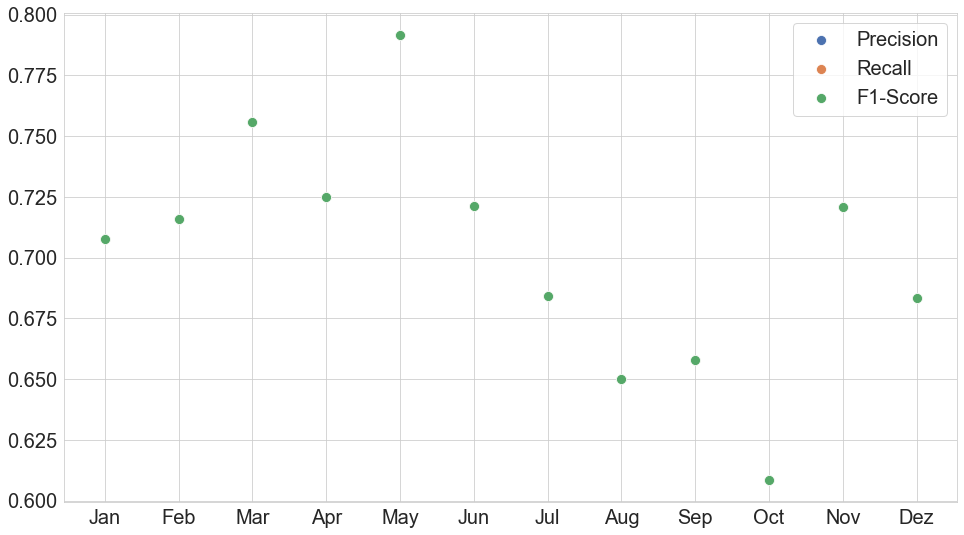

In [954]:
print(total_confusion_matrix)
print(f'Precision: {total_confusion_matrix[1,1]/total_confusion_matrix[:,1].sum()}')
print(f'Recall: {total_confusion_matrix[1,1]/total_confusion_matrix[1,:].sum()}')

plt.figure(figsize=(16,9))
sns.scatterplot(MONTH_NAMES, precision_scores, s=100)
sns.scatterplot(MONTH_NAMES, recall_scores, s=100)
sns.scatterplot(MONTH_NAMES, f1_scores, s=100)
plt.legend(["Precision", "Recall", "F1-Score"])

# Predict on CESMp and CESMf

In [955]:
for month in range(1,12+1):
    month_mask_CESMp = (df_CESMp_reduced_features_scaled["date"].dt.month == month )
    month_mask_CESMf = (df_CESMf_reduced_features_scaled["date"].dt.month == month )

    xgb_CESMp = xgb.DMatrix(df_CESMp_reduced_features_scaled.loc[month_mask_CESMp, feature_names_reduced])
    df_CESMp_reduced_features_scaled.loc[month_mask_CESMp, "prediction_proba"] = sigmoid(models_retrained_list[month-1].predict(xgb_CESMp))
    df_CESMp_reduced_features_scaled.loc[month_mask_CESMp, "prediction"] = (df_CESMp_reduced_features_scaled.loc[month_mask_CESMp, "prediction_proba"]> thresholds_list[month-1]).astype(int)

    xgb_CESMf = xgb.DMatrix(df_CESMf_reduced_features_scaled.loc[month_mask_CESMf, feature_names_reduced])
    df_CESMf_reduced_features_scaled.loc[month_mask_CESMf, "prediction_proba"] = sigmoid(models_retrained_list[month-1].predict(xgb_CESMf))
    df_CESMf_reduced_features_scaled.loc[month_mask_CESMf, "prediction"] = (df_CESMf_reduced_features_scaled.loc[month_mask_CESMf, "prediction_proba"]> thresholds_list[month-1]).astype(int)
                                                 
df_CESMp_reduced_features_scaled["dataset"] = "CESMp"
df_CESMf_reduced_features_scaled["dataset"] = "CESMf"

# Concenate all dataframes

In [956]:
# Create dataframe for actually observed foehn cases 
df_foehn = df_ERA_reduced_features_scaled.loc[:, ["date", "Foehn"]]
df_foehn["dataset"] = "observed_foehn"
df_foehn["ensemble"] = "observed_foehn"
df_foehn.rename({"Foehn": "prediction"}, axis=1, inplace=True)

In [957]:
df_ERA_reduced_features_scaled["dataset"] = "ERA"
df_ERA_reduced_features_scaled["ensemble"] = "ERA"

In [958]:
# Concat all observed foehn, ERAI, CESMp and CESMf prediction
df_foehn_ERA_CESMp_CESMf = pd.concat([df_foehn, 
                                      df_ERA_reduced_features_scaled[["date", "prediction", "dataset", "ensemble"]], 
                                      df_CESMp_reduced_features_scaled[["date", "prediction", "dataset", "ensemble"]], 
                                      df_CESMf_reduced_features_scaled[["date", "prediction", "dataset", "ensemble"]]], 
                                     axis=0, 
                                     ignore_index=True)

In [959]:
# Might be necessary to transform type of date column (should not)
# df_foehn_ERA_CESMp_CESMf["date"] = pd.to_datetime(df_foehn_ERA_CESMp_CESMf["date"], utc=True)

In [960]:
# Create month and year column
df_foehn_ERA_CESMp_CESMf["month"] = df_foehn_ERA_CESMp_CESMf["date"].dt.month
df_foehn_ERA_CESMp_CESMf["year"] = df_foehn_ERA_CESMp_CESMf["date"].dt.year

In [961]:
# Group dataframe by dataset, ensemble, year, month, and prediction and calculate mean
df_foehn_ERA_CESMp_CESMf[["date", "year", "month", "dataset", "ensemble", "prediction"]].groupby(["dataset"], axis=0, as_index=False).mean()

,dataset,year,month,prediction
0,CESMf,2095.500000,6.526027,0.059008
1,CESMp,1995.500000,6.526027,0.059818
2,ERA,2000.831728,6.486519,0.065782
3,observed_foehn,2000.831728,6.486519,0.065800


In [962]:
# Group dataframe by dataset, ensemble, year, month, and prediction and calculate mean
df_monthly_mean = df_foehn_ERA_CESMp_CESMf[["date", "year", "month", "dataset", "ensemble", "prediction"]].groupby(["dataset", "ensemble", "year", "month"], axis=0, as_index=False).mean()

In [963]:
# Retrieve the test period (1991 until 2000) and future prediction (2091-2100)
test_mask_final_plot = ((1990< df_monthly_mean["year"]) & (df_monthly_mean["year"]<2001)) | (2090< df_monthly_mean["year"])
df_monthly_mean_testset = df_monthly_mean[test_mask_final_plot]

# Create Plots

Saved figure at: /home/chmony/Documents/Results/newgradient/final_comparison_NorthFoehn.pdf


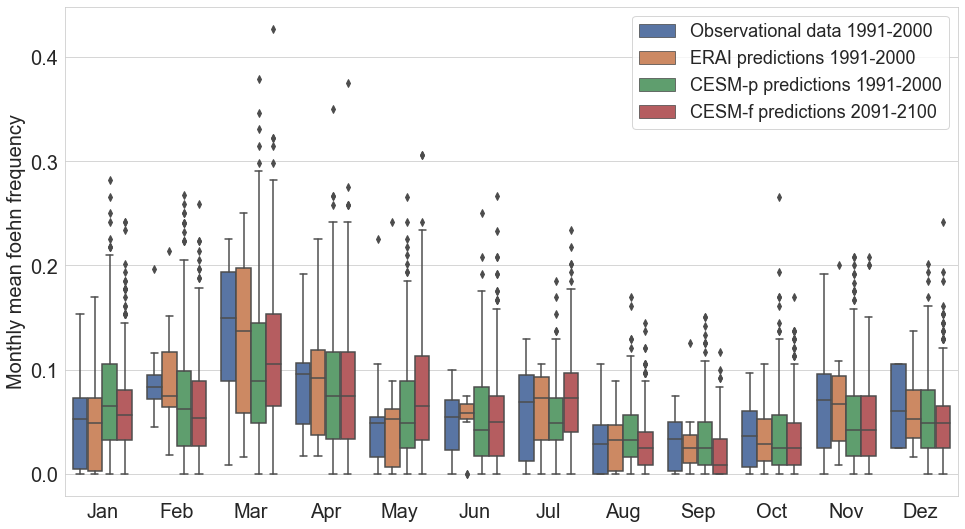

In [964]:
# Plot boxplot for mean foehn frequencies for all datasets
plt.figure(figsize=(16,9))
fig = sns.boxplot(x="month", y="prediction", data=df_monthly_mean_testset, hue="dataset", hue_order=["observed_foehn", "ERA", "CESMp", "CESMf"])
fig.set_xticklabels(MONTH_NAMES);
plt.xlabel("")
plt.ylabel("Monthly mean foehn frequency")

handles, labels = fig.get_legend_handles_labels()
labels = ["Observational data 1991-2000", "ERAI predictions 1991-2000", "CESM-p predictions 1991-2000", "CESM-f predictions 2091-2100" ]
fig.legend(handles, labels, fontsize=18)
save_figure(f"final_comparison_{foehn_type[location]}")

# Second statistical test

Saved figure at: /home/chmony/Documents/Results/newgradient/statistical_test_ERAI_CESMp_NorthFoehn.pdf


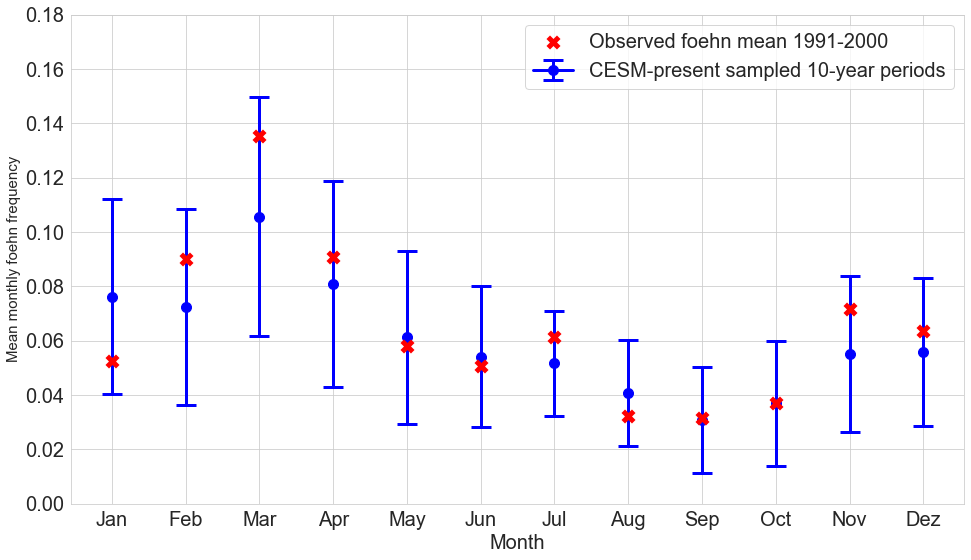

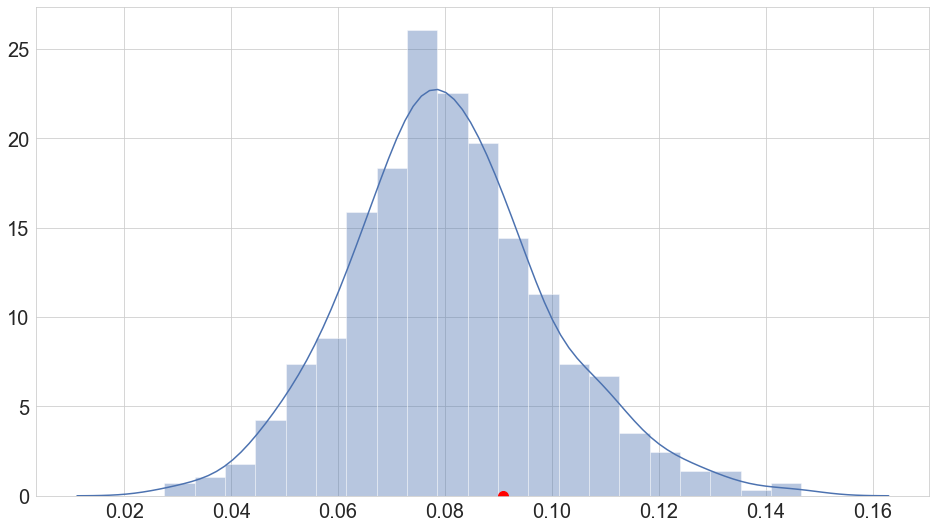

In [965]:
plt.figure(figsize=(16,9))
ax = plt.axes()

for month_test in range(1, 12+1):
    plt.figure(1)
    CESM_test_distribution = []
    df_CESMp_monthly = df_monthly_mean_testset.loc[(df_monthly_mean_testset["dataset"]=="CESMp") & (df_monthly_mean_testset["month"]==month_test),:].reset_index()
    for i in range(500):
        CESM_test_distribution_year = []
        for year in range(1991, 2001):
            CESM_test_distribution_year.append(df_CESMp_monthly.loc[df_CESMp_monthly["year"]==year, "prediction"].sample(1))
        CESM_test_distribution.append(np.mean(CESM_test_distribution_year))
#     if month_test == 2:
#         plt.errorbar(month_test, np.mean(np.array(CESM_test_distribution)), 
#                      yerr = np.array([[2.34*np.array(CESM_test_distribution).std(),3*np.array(CESM_test_distribution).std()]]).T, 
#                      color="b", 
#                      marker="o",
#                      markersize=10, 
#                      linewidth=3, 
#                      capsize=10, 
#                      capthick=3, 
#                      zorder=1)
#         plt.scatter(month_test, (df_sum.loc[(df_sum["original_dataset"]=="ERA") & (df_sum["month"]==month_test), "prediction"]).mean(), 
#                     marker="x", 
#                     color="r", 
#                     s=110, 
#                     linewidth=5, 
#                     zorder=10)
#     else:
    plt.errorbar(month_test, np.mean(np.array(CESM_test_distribution)), 
                 yerr = 2*np.array(CESM_test_distribution).std(), 
                 color="b", 
                 marker="o",
                 markersize=10, 
                 linewidth=3, 
                 capsize=10, 
                 capthick=3, 
                 zorder=1)
    plt.scatter(month_test, (df_monthly_mean_testset.loc[(df_monthly_mean_testset["dataset"]=="observed_foehn") & (df_monthly_mean_testset["month"]==month_test), "prediction"]).mean(), 
                marker="x", 
                color="r", 
                s=110, 
                linewidth=5, 
                zorder=10)

    if month_test==4:
        plt.figure(figsize=(16,9))
        sns.distplot(CESM_test_distribution)
        plt.plot(df_monthly_mean_testset.loc[(df_monthly_mean_testset["dataset"]=="ERA") & (df_monthly_mean_testset["month"]==month_test), "prediction"].mean(),0, 
                "ro", 
                markersize=10)
    
    if month_test==1: # To make plot prettier
        legend = ax.legend(["Observed foehn mean 1991-2000", "CESM-present sampled 10-year periods"])
        
ax.set(xticklabels=MONTH_NAMES, xticks=range(1,12+1))
ax.set_xlabel("Month")
ax.set_ylabel("Mean monthly foehn frequency",fontsize=15)
ax.set_ylim((0,0.18))

save_figure(f"statistical_test_ERAI_CESMp_{foehn_type[location]}")



# Third statistical test

In [966]:
for month_test in range(1, 12+1):
    CESMp_test_distribution = []
    CESMf_test_distribution = []
    df_CESMp_month = df_monthly_mean_testset.loc[(df_monthly_mean_testset["dataset"]=="CESMp") & (df_monthly_mean_testset["month"]==month_test),:].reset_index()
    df_CESMf_month = df_monthly_mean_testset.loc[(df_monthly_mean_testset["dataset"]=="CESMf") & (df_monthly_mean_testset["month"]==month_test),:].reset_index()
    st, p = sci.ks_2samp(df_CESMp_month["prediction"], df_CESMf_month["prediction"])

    print(MONTH_NAMES[month_test-1] +"\t" +str(np.round(p,5)) + "\t" + str(p<0.05))

Jan	0.00047	True
Feb	0.08905	False
Mar	0.04924	True
Apr	0.98649	False
May	0.00087	True
Jun	0.55504	False
Jul	0.0	True
Aug	0.00064	True
Sep	0.00064	True
Oct	0.43697	False
Nov	0.2489	False
Dez	0.03996	True


In [991]:
for month_test in range(1, 12+1):
    CESMp_test_distribution = []
    CESMf_test_distribution = []
    df_CESMp_month = df_monthly_mean_testset.loc[(df_monthly_mean_testset["dataset"]=="CESMp") & (df_monthly_mean_testset["month"]==month_test),:].reset_index()
    df_CESMf_month = df_monthly_mean_testset.loc[(df_monthly_mean_testset["dataset"]=="CESMf") & (df_monthly_mean_testset["month"]==month_test),:].reset_index()
    st, p = sci.ks_2samp(df_CESMp_month["prediction"], df_CESMf_month["prediction"])
    yesno="Yes" if (p<0.05) else "No"
    print(f"{MONTH_NAMES[month_test-1]} & {np.round(p,5)} & {'Yes' if (p<0.05) else 'No'} \\\\ \hline" )

Jan & 0.00047 & Yes \\ \hline
Feb & 0.08905 & No \\ \hline
Mar & 0.04924 & Yes \\ \hline
Apr & 0.98649 & No \\ \hline
May & 0.00087 & Yes \\ \hline
Jun & 0.55504 & No \\ \hline
Jul & 0.0 & Yes \\ \hline
Aug & 0.00064 & Yes \\ \hline
Sep & 0.00064 & Yes \\ \hline
Oct & 0.43697 & No \\ \hline
Nov & 0.2489 & No \\ \hline
Dez & 0.03996 & Yes \\ \hline


# Ensemble deviation

Saved figure at: /home/chmony/Documents/Results/newgradient/final_comparison_ensembles_NorthFoehn.pdf


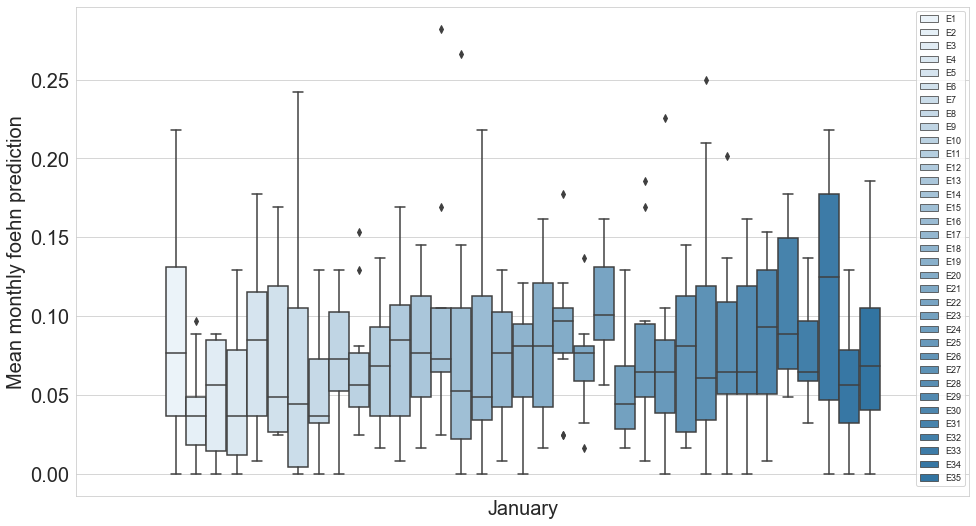

In [967]:
df_ensemble = df_foehn_ERA_CESMp_CESMf.loc[df_foehn_ERA_CESMp_CESMf["dataset"]=="CESMp"].groupby(["ensemble", "year", "month"], as_index=False).mean()

plt.figure(figsize=(16,9))
ax = sns.boxplot(x="month", y="prediction", data=df_ensemble.loc[df_ensemble["month"]==1,:], hue="ensemble", hue_order=["E"+str(i) for i in range(1,35+1)], color="tab:blue")

ax.set(xticks=[])
ax.set_xlabel("January")
ax.set_ylabel("Mean monthly foehn prediction")
ax.legend(fontsize=9)

save_figure(f"final_comparison_ensembles_{foehn_type[location]}")

# Plot weathermaps

In [968]:
df_ERA_raw_temp_adjusted = df_ERA_raw.copy()

temp_columns = df_ERA_raw_temp_adjusted.filter(regex="T_").columns
df_ERA_raw_temp_adjusted[temp_columns] = df_ERA_raw_temp_adjusted[temp_columns]+ 273.15
df_ERA_with_stability = calculate_stability(df = df_ERA_raw_temp_adjusted, lats = LATS_CESM_STRING, lons = LONS_CESM_STRING)

df_ERA_with_stability = pd.merge(df_foehn_raw, df_ERA_with_stability, on="date", how="inner")

In [973]:
variable ='SLP'

variable_lvl = {"SLP": "sealevel",
                "Z": "850",
                "T": "850",
                "DELTAPHI": "700",
                "U": "700",
                "V": "700"}

unit = {"SLP": "hPa",
        "Z": "meters",
        "T": "K",
        "DELTAPHI": "K",
        "U": "m/s",
        "V": "m/s"}


# # Altdorf
# v_limits = {"SLP": [1003, 1022],
#             "Z": [1360, 1570],
#             "T": [3+273, 10.5+273],
#             "DELTAPHI": [5,12],
#             "U":[5,15],
#             "V":[5,15]}

# # Piotta
# v_limits = {"SLP": [1013, 1025],#[1003, 1018],
#             "Z": [1460, 1530],#[1350, 1520],
#             "T": [-1+273.15, 6+273.15],
#             "DELTAPHI": [5.5, 12.5], #[6,11],
#             "U":[5,15],
#             "V":[5,15]}

# Lugano
v_limits = {"SLP": [1009, 1027.5],#[1003, 1018],
            "Z": [1420, 1581],#[1350, 1520],
            "T": [-3+273, 7.05+273],
            "DELTAPHI": [4, 14.05], #[6,11],
            "U":[5,15],
            "V":[5,15]}


df_importances = generate_coordinates_from_feature_label(most_important_features, variable)
#df_importances["importance"] = np.log(df_importances["importance"])

In [974]:
df_importances

,variable,lat1,lon1,lat2,lon2,importance
0,SLP,4476,750,4853,750,3531.297201
1,SLP,4853,1250,4947,1250,1787.839058
2,SLP,4287,375,4382,375,1069.225313
3,SLP,4287,500,4382,625,539.274151
4,SLP,4476,1125,4853,875,3100.425721
5,SLP,4476,1125,4853,1000,439.736526
6,SLP,4382,1250,4382,1500,171.054587
7,SLP,4476,1500,4853,750,126.817635
8,SLP,4476,1250,4853,750,1325.833703
9,SLP,4287,500,4287,750,262.836942


Saved figure at: /home/chmony/Documents/Results/newgradient/weathermap_SLP_sealevel_ERA-Interim_NorthFoehn.pdf'
Saved figure at: /home/chmony/Documents/Results/newgradient/weathermap_SLP_sealevel_CESM-present_NorthFoehn.pdf'
Saved figure at: /home/chmony/Documents/Results/newgradient/weathermap_SLP_sealevel_CESM-future_NorthFoehn.pdf'
Saved figure at: /home/chmony/Documents/Results/newgradient/weathermap_Z_850_ERA-Interim_NorthFoehn.pdf'
Saved figure at: /home/chmony/Documents/Results/newgradient/weathermap_Z_850_CESM-present_NorthFoehn.pdf'
Saved figure at: /home/chmony/Documents/Results/newgradient/weathermap_Z_850_CESM-future_NorthFoehn.pdf'
Saved figure at: /home/chmony/Documents/Results/newgradient/weathermap_T_850_ERA-Interim_NorthFoehn.pdf'
Saved figure at: /home/chmony/Documents/Results/newgradient/weathermap_T_850_CESM-present_NorthFoehn.pdf'
Saved figure at: /home/chmony/Documents/Results/newgradient/weathermap_T_850_CESM-future_NorthFoehn.pdf'
Saved figure at: /home/chmony/D

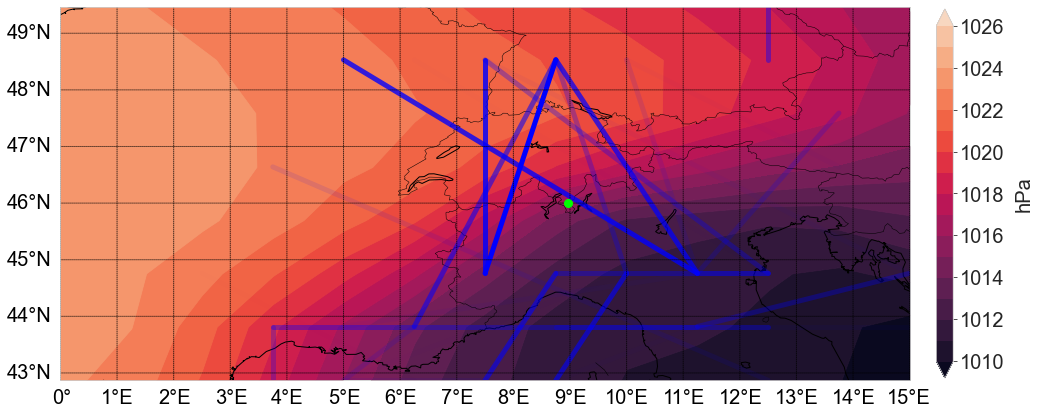

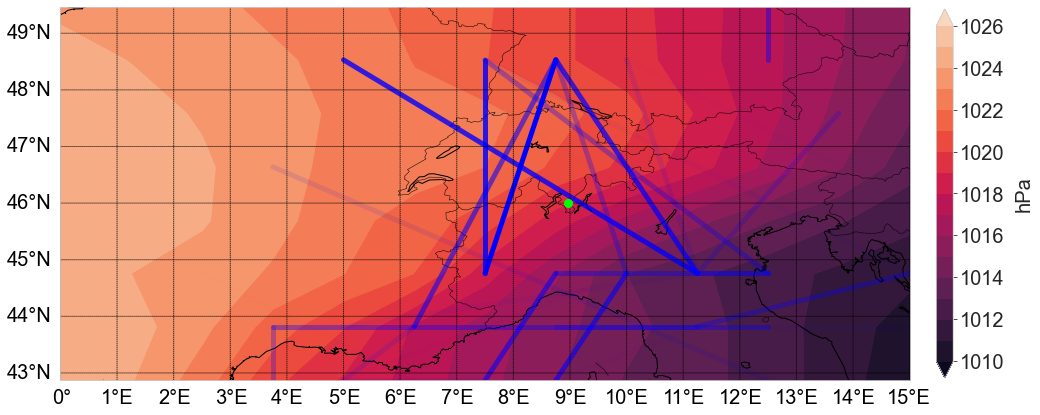

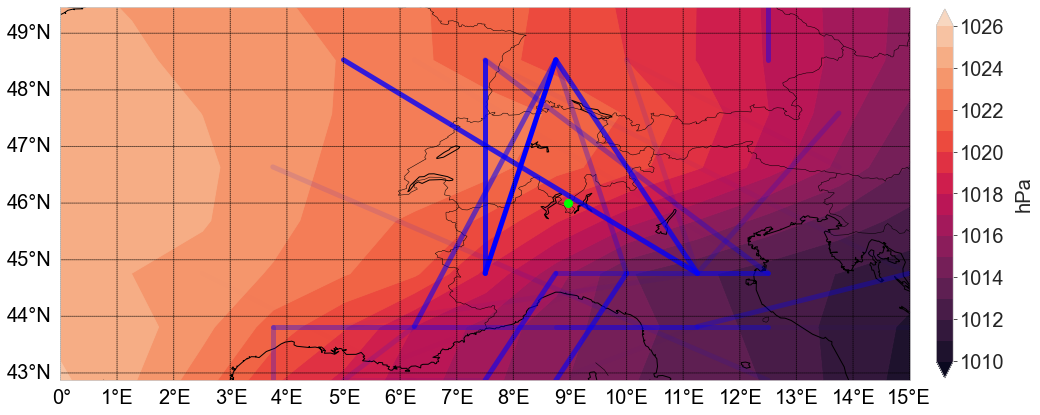

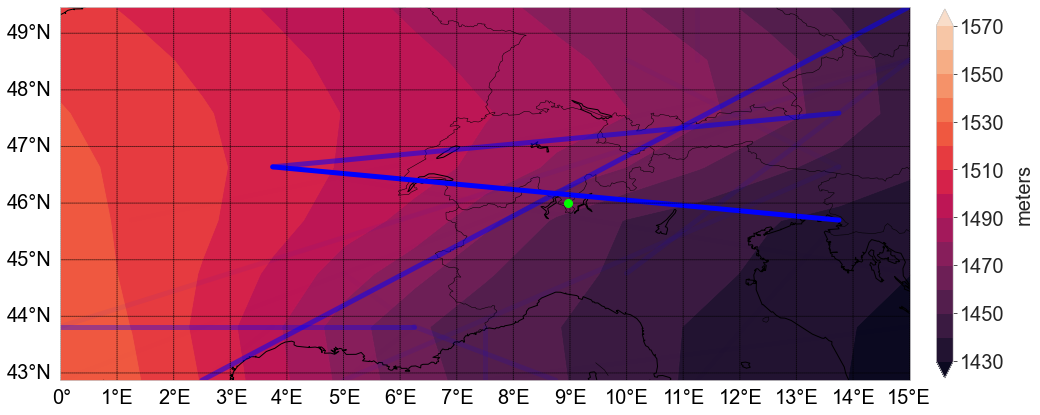

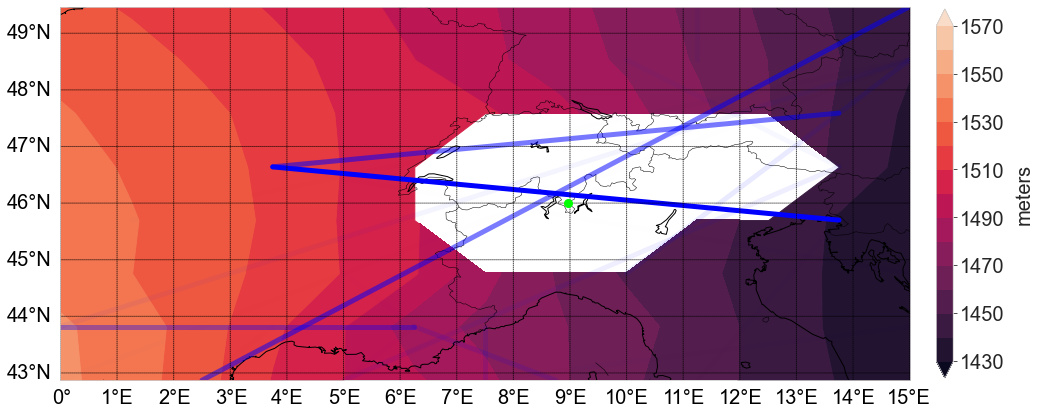

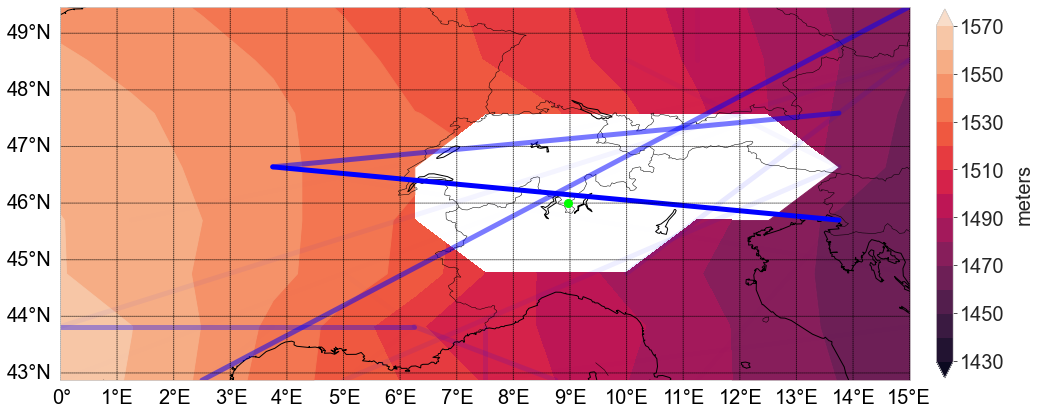

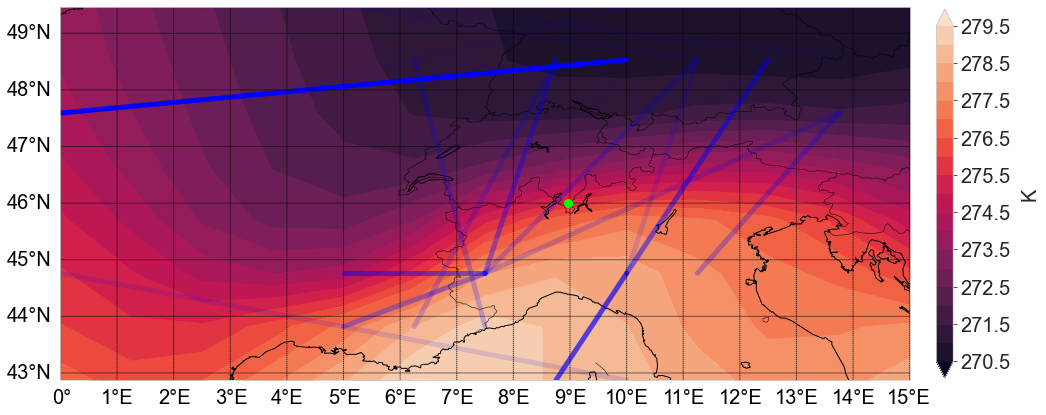

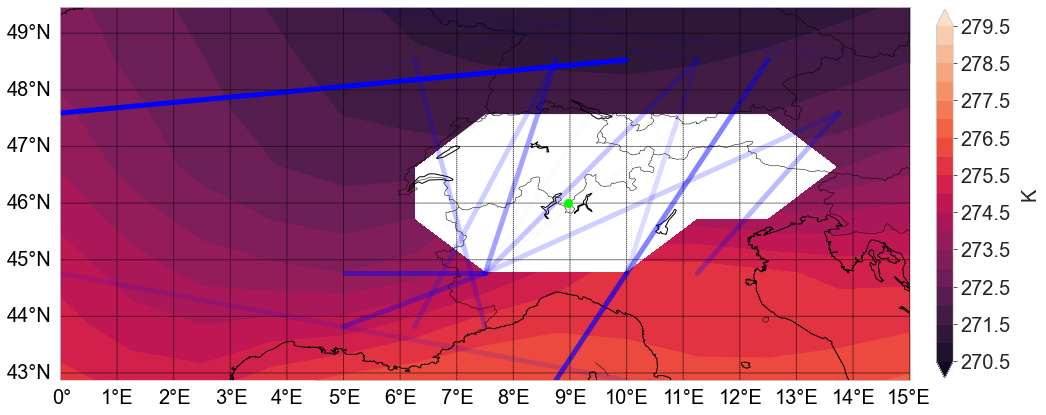

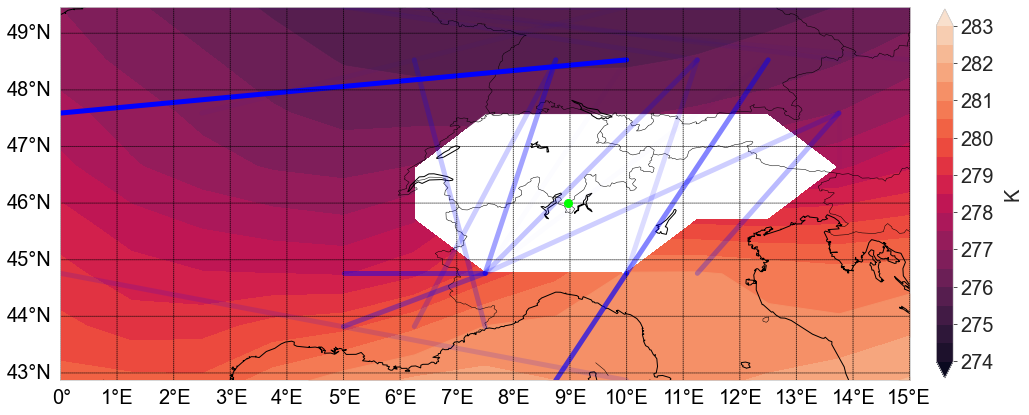

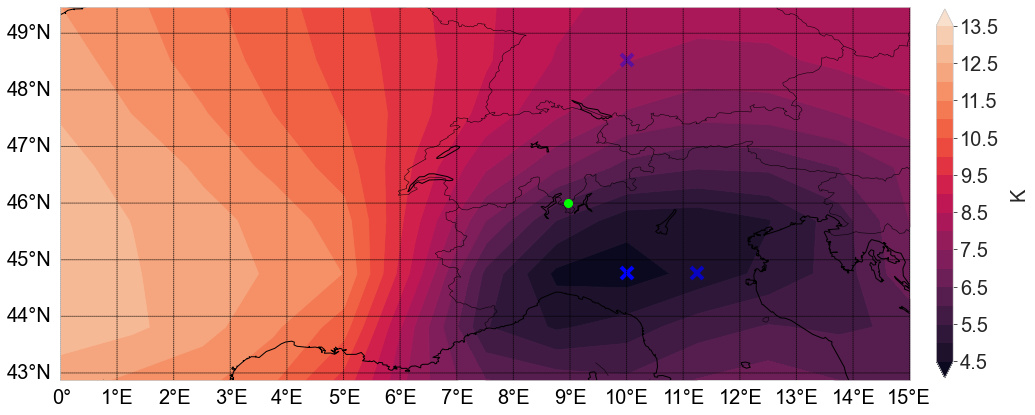

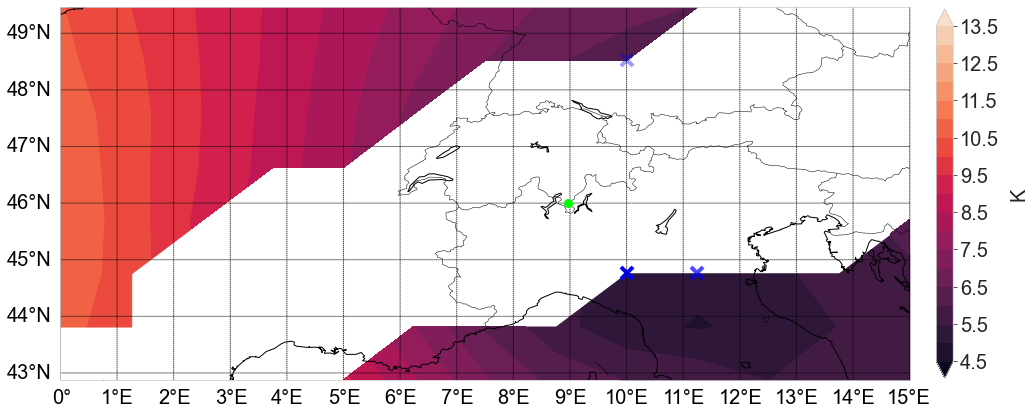

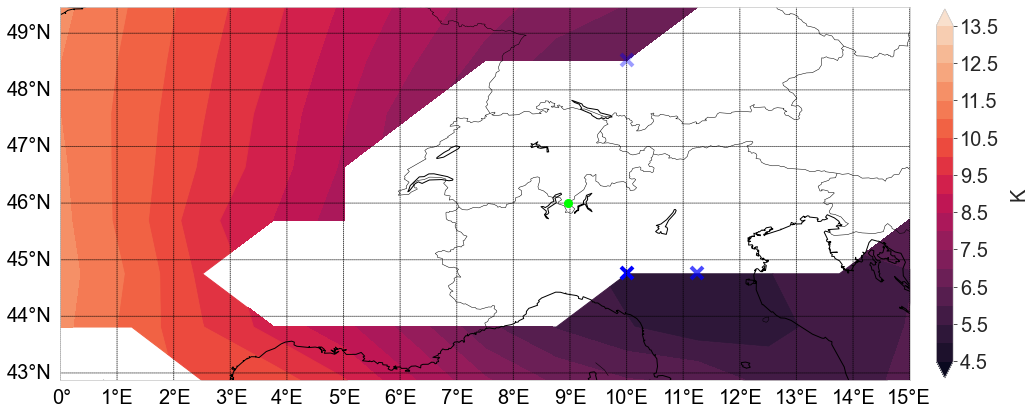

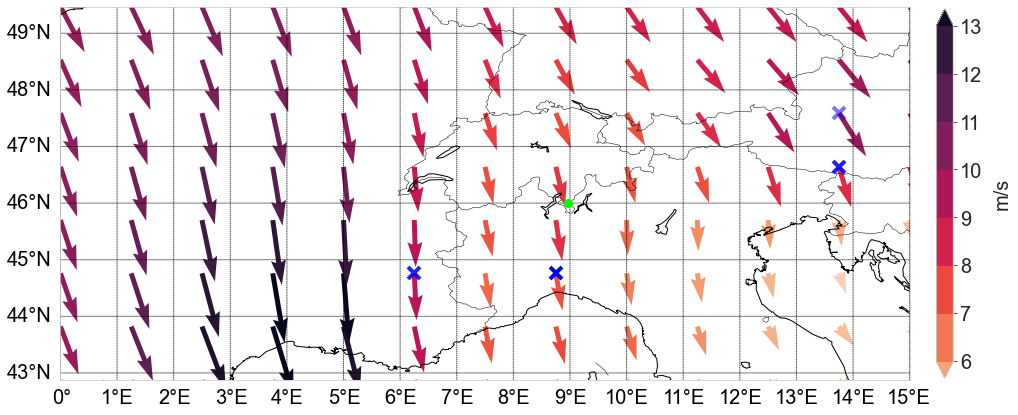

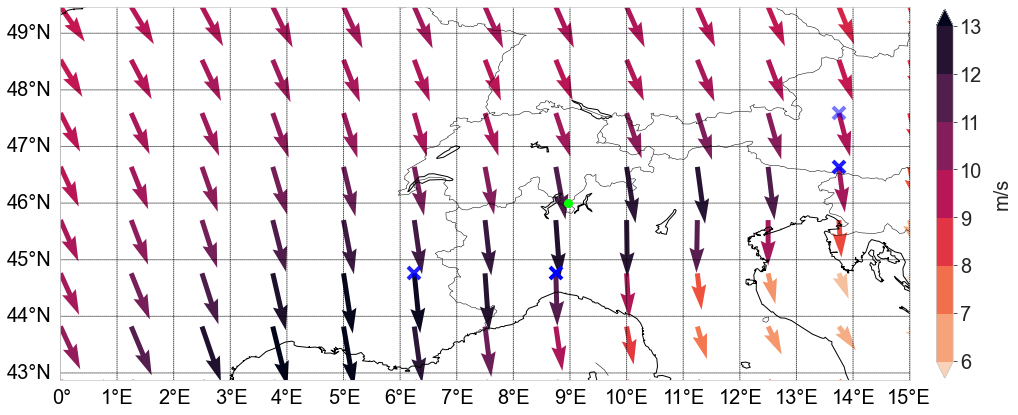

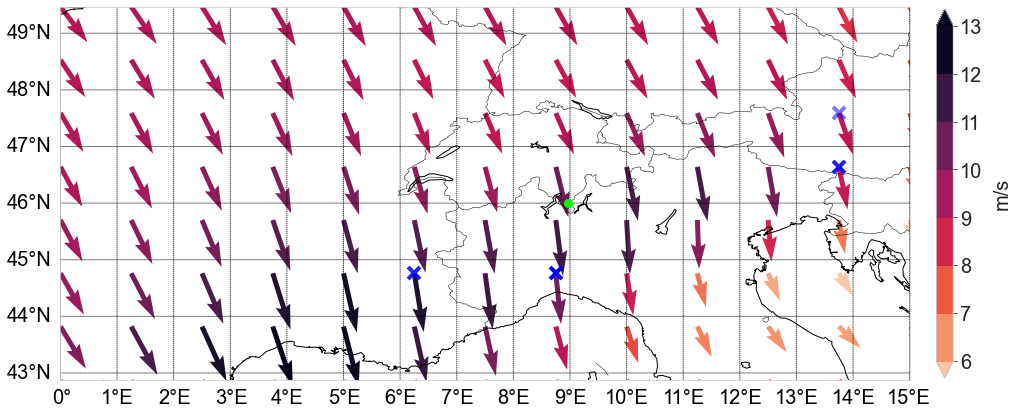

In [975]:
# kwargs = {"variable": variable,
#           "variable_lvl": variable_lvl[variable],
#           "unit": unit[variable],
#           "vmin": v_limits[variable][0],
#           "vmax": v_limits[variable][1],
#           "lats_labels": LATS_CESM_STRING, 
#           "lons_labels": LONS_CESM_STRING, 
#           "df_importances": df_importances}


for variable in list(variable_lvl.keys())[0:-1]:
    df_importances = generate_coordinates_from_feature_label(most_important_features, variable)
    #df_importances["importance"] = np.log(df_importances["importance"])
    kwargs = {"variable": variable,
          "variable_lvl": variable_lvl[variable],
          "unit": unit[variable],
          "vmin": v_limits[variable][0],
          "vmax": v_limits[variable][1],
          "lats_labels": LATS_CESM_STRING, 
          "lons_labels": LONS_CESM_STRING, 
          "df_importances": df_importances}
    
    # These are created with the RF
#     plot_mean_foehn_condition_for_one_model(**kwargs, 
#                                             model= f"OBS_{foehn_type[location]}", 
#                                             df = df_ERA_with_stability.loc[:,:], 
#                                             foehn = df_ERA_with_stability.loc[:, "Foehn"], 
#                                             )

    plot_mean_foehn_condition_for_one_model(**kwargs,
                                            model= f"ERA-Interim_{foehn_type[location]}",
                                            df = df_ERA_with_stability.loc[:,:], 
                                            foehn = df_ERA_reduced_features_scaled.loc[:, "prediction"], 
                                            )

    plot_mean_foehn_condition_for_one_model(**kwargs, 
                                            model= f"CESM-present_{foehn_type[location]}", 
                                            df = df_CESMp.loc[:,:], 
                                            foehn = df_CESMp_reduced_features_scaled.loc[:, "prediction"], 
                                            )
    
    if variable =="T":
        kwargs["vmin"] += 3.5
        kwargs["vmax"] += 3.5
    plot_mean_foehn_condition_for_one_model(**kwargs, 
                                            model= f"CESM-future_{foehn_type[location]}",
                                            df = df_CESMf.loc[:,:], 
                                            foehn = df_CESMf_reduced_features_scaled.loc[:, "prediction"], 
                                            )

In [971]:
most_important_features

{'diff_SLP_4476_750_sealevel_SLP_4853_750_sealevel': 3531.2972012594246,
 'diff_Z_4570_1375_850_Z_4664_375_850': 19059.867096427275,
 'diff_Z_4287_875_850_Z_4382_625_850': 2190.685307776697,
 'diff_PHIT_4287_875_850_PHIT_4476_1000_850': 987.433766575889,
 'diff_SLP_4853_1250_sealevel_SLP_4947_1250_sealevel': 1787.8390579015995,
 'diff_SLP_4287_375_sealevel_SLP_4382_375_sealevel': 1069.2253132597405,
 'diff_SLP_4287_500_sealevel_SLP_4382_625_sealevel': 539.2741511706301,
 'diff_SLP_4476_1125_sealevel_SLP_4853_875_sealevel': 3100.425720610489,
 'diff_Z_4287_250_700_Z_4947_1500_700': 9899.661126008119,
 'V_4476_625_850': 882.6773928585783,
 'diff_SLP_4476_1125_sealevel_SLP_4853_1000_sealevel': 439.73652586761744,
 'diff_SLP_4382_1250_sealevel_SLP_4382_1500_sealevel': 171.05458681956333,
 'diff_SLP_4476_1500_sealevel_SLP_4853_750_sealevel': 126.8176347302943,
 'diff_PHIT_4476_750_850_PHIT_4853_1125_850': 337.8191126574459,
 'DELTAPHI_4476_1000_700': 548.636287759327,
 'diff_Z_4382_0_700_Z_